In [1]:
import pandas as pd
import matplotlib as plt
%matplotlib inline

In [2]:
import psycopg2 as pg

In [3]:
conn = pg.connect("host=localhost dbname=poe user=postgres")

In [4]:
df = pd.read_sql_query('''SELECT * FROM offers where LIMIT 1000000;''', conn)

DatabaseError: Execution failed on sql 'SELECT * FROM offers where LIMIT 1000000;': syntax error at or near "LIMIT"
LINE 1: SELECT * FROM offers where LIMIT 1000000;
                                   ^


In [58]:
df.sample(10)

,id,sell,buy,conversion_rate,stock,league,account_name,category,public,stash_type,created_at,change_id
417835,2508702,Orb of Fusing,chaos,0.243902,41,Harvest,2d6_XD,currency,True,CurrencyStash,2020-06-22 13:59:59.780580,734695014-748642523-713970214-808294985-770952308
54786,2145650,Verdant Oil,chaos,1.000000,2,Harvest,TreezyMonster,currency,True,PremiumStash,2020-06-22 10:15:51.936544,734479781-748430461-713766188-808060772-770728404
880800,2971650,Amber Oil,chaos,1.000000,14,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-22 18:18:57.805884,734984899-748934436-714252518-808615878-771267201
257487,2348357,The Dark Mage,vaal,10.000000,3,Standard,sidtherat,cards,True,DivinationCardStash,2020-06-22 12:26:53.773557,734597554-748548235-713878105-808189264-770854373
2417,2093278,Humility,chaos,2.000000,1,Harvest,엘방0,cards,True,PremiumStash,2020-06-22 09:49:21.083988,734438033-748383757-713732420-807987562-770675912
429321,2520190,Blacksmith's Whetstone,alch,0.500000,43,Harvest,NomNoomNom,currency,True,CurrencyStash,2020-06-22 14:06:29.844117,734701933-748649681-713977233-808302320-770959500
735969,2826824,Orb of Regret,chaos,1.000000,3,Hardcore Harvest,Madestino66,currency,True,CurrencyStash,2020-06-22 16:55:08.464356,734889383-748840812-714161138-808516366-771162730
851288,2942158,Orb of Regret,chaos,1.200000,5,Harvest,DavidandNancy,currency,True,CurrencyStash,2020-06-22 18:02:40.985183,734965576-748915646-714234287-808595111-771243932
775142,2866006,The Dreamland,chaos,1.000000,1,Harvest,Xx_Vernum_xX,cards,True,PremiumStash,2020-06-22 17:17:52.698505,734914650-748865631-714185359-808542617-771190321
318662,2409510,Orb of Alteration,jew,3.833333,1,Standard,wesleygjr,currency,True,QuadStash,2020-06-22 13:02:55.306625,734633536-748584172-713911420-808229675-770890533


In [66]:
df_harvest = df[df["league"] == "Harvest"]

In [60]:
harvest_records = df_harvest.to_dict(orient='records')

## Basic ES AH

Write all events straight into some nested dictionary data structure. Group by league-account_name and sell-buy.

In [70]:
auction_house = dict()
upserts = 0

for record in harvest_records:
    player_key = "{}-{}".format(record["league"], record["account_name"])
    if player_key not in auction_house:
        auction_house[player_key] = dict()
    
    offer_key = "{}-{}".format(record["sell"], record["buy"])
    if offer_key not in auction_house[player_key]:
        auction_house[player_key][offer_key] = 1
    else:
        upserts = upserts + 1
        
print("~{}% upserts ".format(round(upserts/len(harvest_records) * 100, 2)))
print("The higher the upsert percentage, the more important are fast write updates.")

~84.8% upserts 
The higher the upsert percentage, the more important are fast write updates


## ES AH Changelogs

Nearly 85% upserts is quite a lot. Maybe generating changelogs in between two events lets us understand the player/seller/buyer behaviour better.

Lets focus on **what changed** and **how long it took** for changes to happen.

So, same code as before, but instead of offers, we track diffs, which we can look at later.

In [75]:
auction_house = dict()
diffs = []

for record in harvest_records:
    player_key = "{}-{}".format(record["league"], record["account_name"])
    if player_key not in auction_house:
        auction_house[player_key] = dict()
    
    offer_key = "{}-{}".format(record["sell"], record["buy"])
    if offer_key not in auction_house[player_key]:
        auction_house[player_key][offer_key] = record
    else:
        before = auction_house[player_key][offer_key]
        after = record
        diffs.append((before, after))
        
print("~{}% diffs; Should be same as upserts ".format(round(len(diffs)/len(harvest_records) * 100, 2)))

~84.8% diffs; Should be same as upserts 


Example diff via `diffs[0]` shows:

```
({'id': 2091110,
  'sell': 'Humility',
  'buy': 'chaos',
  'conversion_rate': 2.0,
  'stock': 1,
  'league': 'Harvest',
  'account_name': 'Laisrean1996',
  'category': 'cards',
  'public': True,
  'stash_type': 'PremiumStash',
  'created_at': Timestamp('2020-06-22 09:48:25.177319'),
  'change_id': '734433376-748378789-713728752-807970546-770670365'},
 {'id': 2091111,
  'sell': 'Humility',
  'buy': 'chaos',
  'conversion_rate': 2.0,
  'stock': 1,
  'league': 'Harvest',
  'account_name': 'Laisrean1996',
  'category': 'cards',
  'public': True,
  'stash_type': 'PremiumStash',
  'created_at': Timestamp('2020-06-22 09:48:25.177319'),
  'change_id': '734433376-748378789-713728752-807970546-770670365'})
```

So apparently, there are updates that essentially don't change anything. Even the `change_id` is the same. So either that guy moved this `Humility` card within his `PremiumStash` or to another one or PoE's Stash Tab API creates a lot of **wasteful** events.

### Diff Pairs

Let's check how many **actual** diffs there actually are, having changes in `conversion_rate`, `stock`, and foremost `created_at` or alternatively `change_id`.

In [83]:
actual_diffs = [x for x in diffs if x[0]["change_id"] != x[1]["change_id"]]
non_diffs = [x for x in diffs if x[0]["change_id"] == x[1]["change_id"]]
print("Non-Diffs: {} - Actual Diffs: {}".format(len(non_diffs), len(actual_diffs)))

Non-Diffs: 3350 - Actual Diffs: 723780


In [84]:
actual_diffs[0]

({'id': 2093776,
  'sell': "The Tinkerer's Table",
  'buy': 'chaos',
  'conversion_rate': 1.0,
  'stock': 1,
  'league': 'Harvest',
  'account_name': 'dalianbayq',
  'category': 'cards',
  'public': True,
  'stash_type': 'PremiumStash',
  'created_at': Timestamp('2020-06-22 09:49:35.173066'),
  'change_id': '734439118-748384991-713733234-807991740-770677394'},
 {'id': 2094131,
  'sell': "The Tinkerer's Table",
  'buy': 'chaos',
  'conversion_rate': 1.0,
  'stock': 1,
  'league': 'Harvest',
  'account_name': 'dalianbayq',
  'category': 'cards',
  'public': True,
  'stash_type': 'PremiumStash',
  'created_at': Timestamp('2020-06-22 09:49:44.261947'),
  'change_id': '734439785-748385864-713733772-807994347-770678268'})

### Example Diff Series

In [130]:
df = pd.read_sql_query('''SELECT * FROM offers where account_name = 'dalianbayq' and sell = 'The Tinkerer''s Table' order by created_at asc;''', conn)
df

,id,sell,buy,conversion_rate,stock,league,account_name,category,public,stash_type,created_at,change_id
0,10949,Ancient Orb,chaos,10.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 15:08:38.960594,731812123-745797048-711246907-805092736-767901611
1,92409,Ancient Orb,chaos,10.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 16:22:22.065320,732211148-746206506-711629840-805514314-768328358
2,108929,Ancient Orb,chaos,6.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 16:41:54.868709,732227833-746225316-711645121-805531744-768345737
3,119318,Ancient Orb,chaos,6.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 16:54:20.168454,732237959-746236950-711657908-805543521-768356954
4,124532,Ancient Orb,chaos,6.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 17:00:54.950919,732243293-746242125-711665565-805549420-768363940
...,...,...,...,...,...,...,...,...,...,...,...,...
9091,35650721,Golden Oil,exalted,1.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:09:27.697332,751808930-765590641-730359276-826690611-788509278
9092,35650722,Simple Sextant,chaos,1.00,31,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:09:27.697332,751808930-765590641-730359276-826690611-788509278
9093,35671550,Golden Oil,exalted,1.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:20:15.606927,751817306-765599868-730367786-826700552-788517958
9094,35671551,Simple Sextant,chaos,1.00,31,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:20:15.606927,751817306-765599868-730367786-826700552-788517958


In [127]:
df["time"] = df["created_at"].astype("datetime64")
df.groupby([df["time"].dt.day, df["time"].dt.hour, df["time"].dt.minute]).count()["time"]

time  time  time
22    9     49      3
            59      2
      10    33      1
            48      1
            57      1
      11    9       1
            26      1
      12    56      1
      13    4       1
      14    16      1
      15    20      1
      23    48      1
23    2     6       1
      22    43      1
24    0     23      1
Name: time, dtype: int64

### Example Activity for Specific Player

In [131]:
df = pd.read_sql_query('''SELECT * FROM offers where account_name = 'Skiazos' order by created_at asc;''', conn)
df

,id,sell,buy,conversion_rate,stock,league,account_name,category,public,stash_type,created_at,change_id
0,10949,Ancient Orb,chaos,10.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 15:08:38.960594,731812123-745797048-711246907-805092736-767901611
1,92409,Ancient Orb,chaos,10.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 16:22:22.065320,732211148-746206506-711629840-805514314-768328358
2,108929,Ancient Orb,chaos,6.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 16:41:54.868709,732227833-746225316-711645121-805531744-768345737
3,119318,Ancient Orb,chaos,6.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 16:54:20.168454,732237959-746236950-711657908-805543521-768356954
4,124532,Ancient Orb,chaos,6.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-06-20 17:00:54.950919,732243293-746242125-711665565-805549420-768363940
...,...,...,...,...,...,...,...,...,...,...,...,...
9091,35650721,Golden Oil,exalted,1.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:09:27.697332,751808930-765590641-730359276-826690611-788509278
9092,35650723,Perandus Coin,chaos,0.02,2944,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:09:27.697332,751808930-765590641-730359276-826690611-788509278
9093,35671551,Simple Sextant,chaos,1.00,31,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:20:15.606927,751817306-765599868-730367786-826700552-788517958
9094,35671550,Golden Oil,exalted,1.00,1,Harvest,Skiazos,currency,True,CurrencyStash,2020-07-05 06:20:15.606927,751817306-765599868-730367786-826700552-788517958


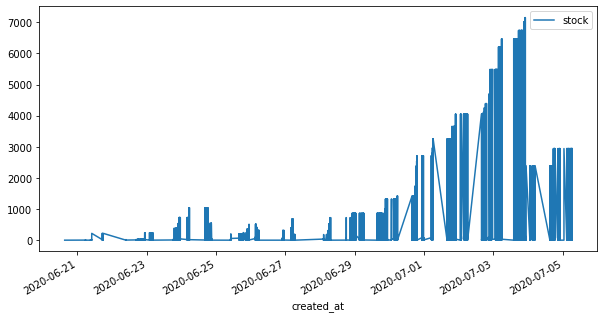

In [163]:
df["time"] = df["created_at"].astype("datetime64")
time = df.groupby([df["time"].dt.month, df["time"].dt.day, df["time"].dt.hour, df["time"].dt.minute]).count()[["time"]]
df.plot(figsize=(10,5), x="created_at", y="stock")

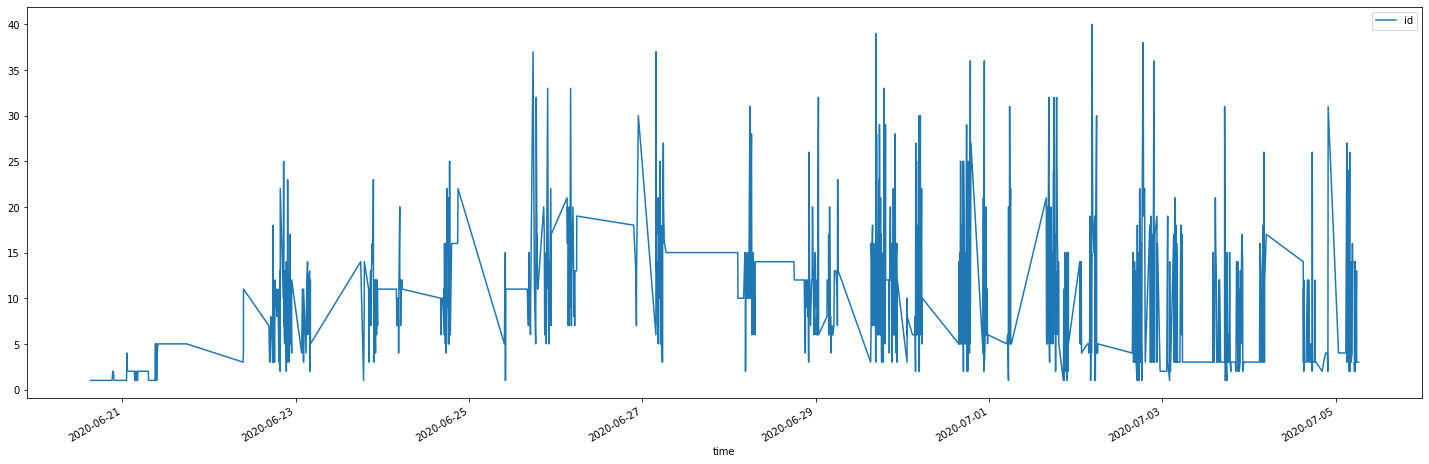

In [207]:
df.groupby([df["time"]]).count().plot(y="id", figsize=(25,8))

In [ ]:
xdf.plot.scatter(figsize=(25,5), y="id", x="created_at")